interactive(children=(IntSlider(value=10, description='# of Trades', min=1), IntSlider(value=5, description='R…

<function __main__.exposure_simulation(n, m, addOn)>

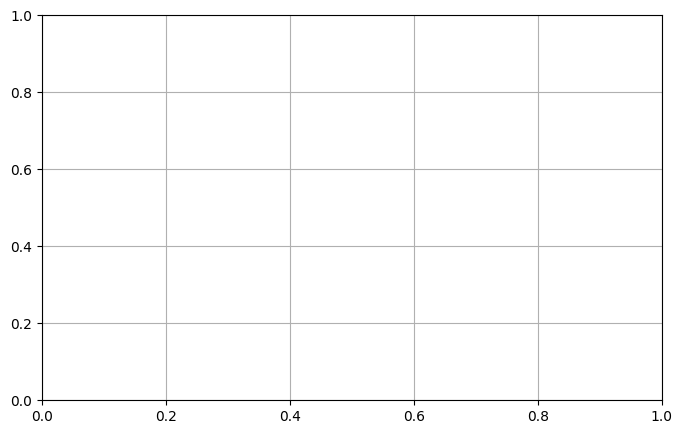

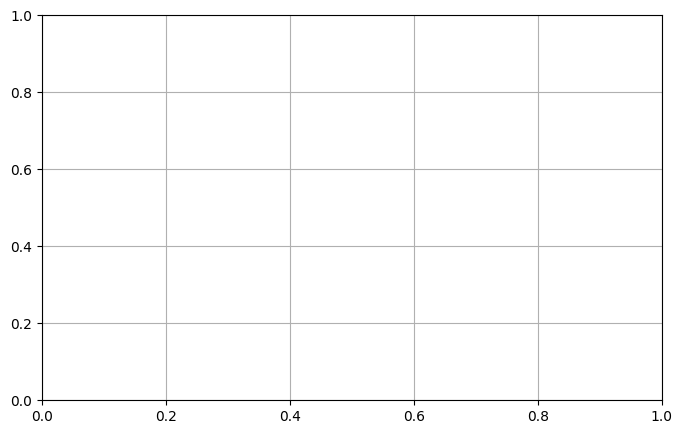

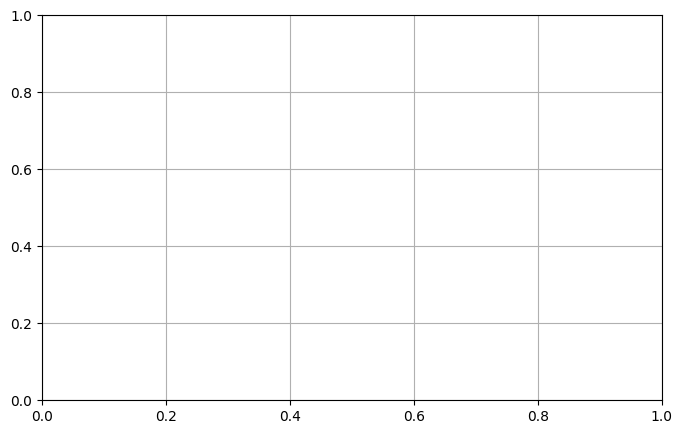

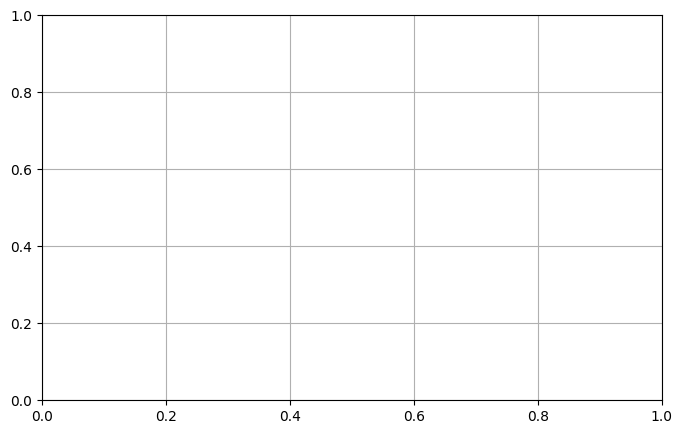

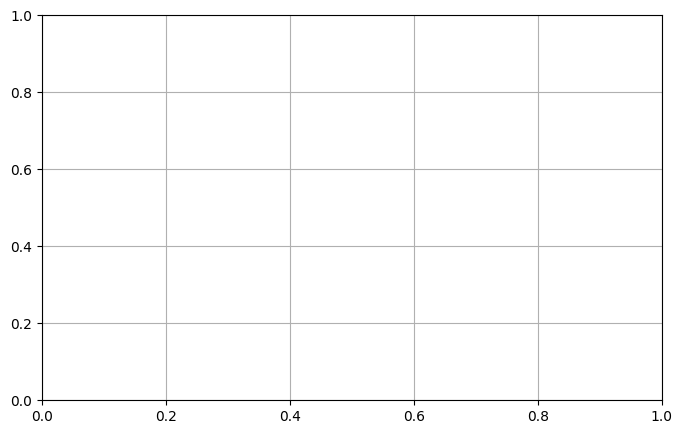

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import math
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

# We define the exposure (MTM) calculator
def currentExposure(mtm):
    return max(0,mtm)

# We calculate the notional
def addOn(notional, addOnFactor):
    return notional*addOnFactor

# The total exposure is the sum of the two above functions
def totalExposure(mtm, notional, addOnFactor):
    currExp = currentExposure(mtm)
    currAddOn = addOn(notional, addOnFactor)
    return currExp + currAddOn

# The brute force takes all the impacts, sums them together, and calculates the bulk exposure
def psrBruteForce(position, impacts, addOnFactor, bf_list):

    # The way it works: We input up a list called 'bf_list', and for each step, we sum all the impacts into a variable called 'total' and 
    # calculate the exposure. We then add that number to the list, and proceed to the next impact/trade.

    total = 0
    totalMtm = position[0]
    totalNotional = position[1]
    
    total += totalExposure(totalMtm, totalNotional, addOnFactor)
    bf_list.append(total)
    
    for i in range(len(impacts)):

        totalMtm += impacts[i,0]
        totalNotional += impacts[i,1]
        total = totalExposure(totalMtm, totalNotional, addOnFactor)
        bf_list.append(total)
    
    return bf_list


def psrConservative(position, impacts, addOnFactor, cons_list):
    
    # The way it works: We input up a list called 'cons_list', and for each step, we calculate the exposure for each individual 
    # impact and add that to the total. We then add that number to the list, and proceed to the next impact/trade.

    total = 0
    total += totalExposure(position[0], position[1], addOnFactor)
    cons_list.append(total)

    for i in range(len(impacts)):
        total += totalExposure(impacts[i,0], impacts[i,1], addOnFactor)
        cons_list.append(total)

    return cons_list

def psrLinearisation(position, impacts, addOnFactor, lin_list):

    # The way it works: We input up a list called 'lin_list'. We then calculate the baseline exposure and use that in each step of our calculation.
    # We then take the exposure for each impact and 'subtract' from baseline exposure (MXWiki can explain this better)

    total = 0
    position_exposure = totalExposure(position[0], position[1], addOnFactor)
    total += position_exposure
    lin_list.append(position_exposure)

    for i in range(len(impacts)):
        total += totalExposure(position[0]+impacts[i,0], position[1]+impacts[i,1], addOnFactor) - position_exposure
        
        # We only want positive exposures added to our list since this will results in the linearisation approach producing incorrect answers
        lin_list.append(max(0, total))

        # lin_list.append(total)

    return lin_list

def psrAverages(position, impacts, addOnFactor, n, avg_list):

    # This method works similarly to the Linearisation approach.

    total = 0
    position_exposure = totalExposure(position[0], position[1], addOnFactor)
    total += position_exposure
    avg_list.append(position_exposure)

    for i in range(len(impacts)):
        total += 1/n*(totalExposure(position[0]+n*impacts[i,0], position[1]+n*impacts[i,1], addOnFactor) - position_exposure)
        avg_list.append(total)

    return avg_list


def remove_outliers(data, threshold = 2):

    # The growth in exposure from the baseline can be exceptionally high for a small number of trades (since we are going from 0% difference to, for instance, a 20% differnce depending on the impacts we use).
    # This function removes the outliers that impact our analysis of the graph, by using standard mean and variance approaches

    n = len(data)
    mean = np.mean(data[int(n/4):])
    std_dev = np.std(data[int(n/4):])
    cleaned_data = []

    for i in range(len(data)):

        if mean-threshold*std_dev < data[i] < mean+threshold*std_dev:
            cleaned_data.append(data[i])
        else:
            if i == 0:
                cleaned_data.append(data[i+1])
            elif i == len(data) - 1:
                cleaned_data.append(data[i-1])
            else:
                cleaned_data.append((data[i-1]+data[i+1])/2)
    return cleaned_data
   

def get_position_impacts(n):
    
    # This function generates the baseline position and the subsequent impacts.

    baseline_position = [400, 2000]
    mtm_notional_matrix = np.zeros((n,2))


    # Here we can set the range of values our impacts can take.
    for i in range(n):

        mtm_notional_matrix[i,0] = random.randint(-200,200)
        mtm_notional_matrix[i,1] = random.randint(0,250)

    return [baseline_position, mtm_notional_matrix]


# the following function prevents the simluation below from regenerating a new dataset (baseline + impacts) for each iteration
position_impacts_state = {"n": 0, "data": None}
def update_position_impacts(n):
    global position_impacts_state
    if position_impacts_state["n"] != n:
        position_impacts_state["n"] = n
        position_impacts_state["data"] = get_position_impacts(n)


# Here we have our main function, which takes the parameters:
# n - number of impacts
# m - how often we refresh the baseline (for every 'm' trades)
# addOn - the addOn factor, which is set by the user

def exposure_simulation(n,m, addOn):
    
    update_position_impacts(n)
    baseline_position, mtm_notional_matrix = position_impacts_state["data"]
    
    addOnVal = addOn

    bf_list = []
    cons_list = []
    lin_list = []
    avg_list = []


    for i in range(int(n/m)):

        [bf_list, cons_list, lin_list, avg_list] = [psrBruteForce(baseline_position, mtm_notional_matrix[m*i:m*(i+1),:], addOnVal, bf_list),
                                                    psrConservative(baseline_position, mtm_notional_matrix[m*i:m*(i+1),:], addOnVal, cons_list),
                                                    psrLinearisation(baseline_position, mtm_notional_matrix[m*i:m*(i+1),:], addOnVal, lin_list),
                                                    psrAverages(baseline_position, mtm_notional_matrix[m*i:m*(i+1),:], addOnVal, n, avg_list)]
        
        mtmRefresh = baseline_position[0]+np.sum(mtm_notional_matrix[m*i:m*(i+1),0])
        notionalRefresh = baseline_position[1] + np.sum(mtm_notional_matrix[m*i:m*(i+1),1])
        
        # We don't want the baseline taking a negative MTM as this messes up our exposure strategies
        baseline_position = [max(0, mtmRefresh), notionalRefresh]

        print("Baseline after refresh " + str(i+1) + ": ", baseline_position)


    ####################    POST-PROCESSING    ####################
    

    # Here we plot our analyses
    
    x = np.linspace(0, n+int(n/m)-1, n+int(n/m))

    plt.figure(figsize=(8,5))
    plt.grid(True)
    plt.plot(x, bf_list, 'b', label = "BF")
    plt.plot(x, cons_list, 'r', label = "Conservative")
    plt.plot(x, lin_list, 'g', label = "Linearisation")
    plt.plot(x, avg_list, 'y', label = "Averages")
    plt.xlabel("Trade Number")
    plt.ylabel("Exposure")


    for i in range(int(n/m)):

        vline_x = (i+1)*(m+1)
        ymin, ymax = plt.ylim()
        plt.axvline(vline_x, color='k', linestyle='--')
        vline_x2 = (i+1)*(m+1)-1
        ymin2, ymax2 = plt.ylim()
        plt.axvline(vline_x2, color='r', linestyle='--')
        plt.text(vline_x, ymax + (ymax - ymin)*0.025, 'RF', ha="center", va = "bottom", color="k")
        plt.text(vline_x2, ymax2 + (ymax2 - ymin2)*0.025, '↻', ha="center", va = "bottom", color="r")

    vline_start = 0
    ymin3, ymax3 = plt.ylim()
    plt.axvline(vline_start, color='b', linestyle='--')
    plt.text(vline_start, ymax3 + (ymax3 - ymin3)*0.025, 'Base', ha="center", va = "bottom", color="b")

    plt.legend()
    plt.show()

    print("Impacts Matrix \n", mtm_notional_matrix)
    
    print("\n")
    
    print("BF list ", bf_list)
    print("Lin List", lin_list)
    
    print("\n")
    
    print("Conservative List", cons_list)
    print("Average List", avg_list)




interact(exposure_simulation,
         n=widgets.IntSlider(min=1, max=100, step=1, value=10, description="# of Trades"),
         m=widgets.IntSlider(min=1, max=100, step=1, value =5, description="Refresh Cycle"),
         addOn = widgets.FloatSlider(min=0,max=1,step=0.01,value=0.50,description="AddOnFactor"),
         )
